# 220324 ~ 220325

# 0. 왼성 되면 안 보고 짜고 시작하기

## 1. loss 마스킹을 하긴 했는데 loss 계산을 전부 포함시켜서 해버림. -> masking한 것들 제외하고 연산할 것. -> 이걸 train step에서 임의로 짜긴 했는데, 내부에서 loss를 정의해서 사용하는 경우 add_loss를 통해서 regularization이 안 됨.

## 2. 값중에 음수가 발생하고 5가 최대인데 5를 넘는 경우 있음.

## 3. train test split을 통한 실험을 하지 않았음.

## 4. activation function에 대한 실험 없었음.

# 5. loss=tf.reduce_sum(tf.math.square(y_pred-y))/tf.reduce_sum(mask) loss를 관측된 obs에 대해서만 error를 제곱한다음 합한다음에 관측된 obs 개수로 나눔. 즉, 관측한 것들의 평균만 이용.

# 6. 첫번째 layer에 activation으로 sigmoid 추가함.

7. regularization을 어떻게 반영할지 고민하다가 일반적으로 self.compiled_loss(y, y_pred, regularization_losses=self.losses) 이렇게 반영하는 것을 보고 그냥 더하면 될 것 같아서 self.losses를 더했다.

8. regularization term 추가하고 나서 한 유저가 평가하는 값들이 한 유저를 기준으로 같은 값이 나옴.
9. Bias에 대한 regularization은 원래 적용 안 함 ?

10. 아예 잘못 생각했는데 loss=tf.reduce_sum(tf.math.square(y_pred-y))임.
[loss는 그냥 sum임. 평균 아님.](loss=tf.reduce_sum(tf.math.square(y_pred-y)))

```python
        pre_Encoder = tf.matmul(self.input_R,V) + mu
        self.Encoder = tf.nn.sigmoid(pre_Encoder)
        pre_Decoder = tf.matmul(self.Encoder,W) + b
        self.Decoder = tf.identity(pre_Decoder)

        pre_rec_cost = tf.multiply((self.input_R - self.Decoder) , self.input_mask_R)
        rec_cost = tf.square(self.l2_norm(pre_rec_cost)) # 그냥 sum임.
        pre_reg_cost = tf.square(self.l2_norm(W)) + tf.square(self.l2_norm(V))
        reg_cost = self.lambda_value * 0.5 * pre_reg_cost
```

- 그리고 l2로 끝이 아니라 제곱해야함.

11. loss tracker 

12. losses를 추가 하는 방법, 명백하게 losses 그냥 더해도 되는지 확인하기

13. 값이 유저를 기준으로 거의 같아지는 상황이 나옴... 왜 ?

14. weight의 initializer truncated_normal 적용함.

15. 데이터가 너무 적어서 overfit이 일어나는 것 같아서 1M짜리로 바꿈.

16. 학습 정보 
- learning rate를 파라미터로 썼다는 것을 알 수 있다. decay_epoch_step을 설정하였다.
- batch_size는 100
- grad_clip 관련해서 공부해야할 것.
- lambda는 10이 디폴트인데 0.1을 제시한 것보면 최적화에서 크게 신경쓰지 않았던 것 같다.
- train_epoch는 2000회로 생각보다 많이 크다.

Namespace(base_lr=0.001, batch_size=100, decay_epoch_step=50, display_step=1, grad_clip=True, hidden_neuron=500, lambda_value=0.1, optimizer_method='Adam', random_seed=1000, train_epoch=2000)



17. train test split에서 각각 rating matrix는 같은 크기를 유지해줬다.

18. 아래는 무슨뜻일까?
```
Follow-
ing [2], we use a default rating of 3 for test users or items
without training observations.
```


19. [exponential decay](
https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay)

20. train test 분리하여 학습해봄. (전적으로 본 논문 코드 참고)

21. test set 샘플들 따로 RMSE 계산하는 것까지 만들 것.

22. 아래가 train test 나눈 후에 validation loss를 계산한 결과임. 
- val_loss는 내가 train_step에서 정의한 수식과 정확히 일치할까 ?
- 굉장히 일찍 overfit이 일어남.

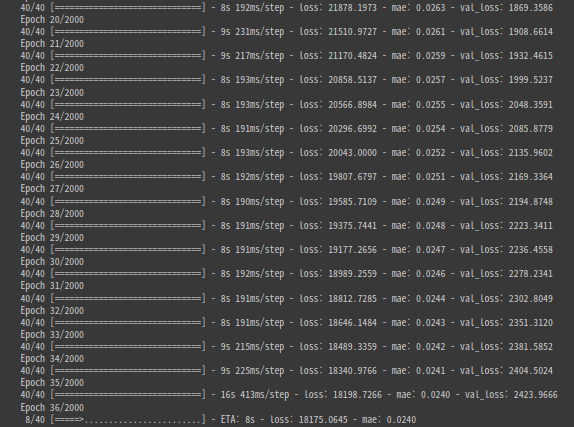

23. train test

24. 코드 전번적으로 순서 점검하고 불필요한 내용들 v1.2에서 제거 할것

25. validation loss가 바르게 구해졌는지 알 수 있는 방법 ?

- 아래가 있을때는 mae까지 나오고 없을때는 mae가 안 나옴. 일단 test_step을 정의하냐에 따라서 차이가 있음.
```python
  
  def test_step(self,data):
    x,y = data
    
    mask = y !=0
    mask=tf.cast(mask, tf.float32)
    
    # masking을 뺀 후에 해서 비교해보기
    
    with tf.GradientTape() as tape:
      y=tf.cast(y, tf.float32)
      y_pred=self(x,training=False)
      y_pred=tf.cast(y_pred, tf.float32)
      y_pred=tf.multiply(y_pred,mask)
      dev=tf.multiply((y-y_pred),mask)
      
      #loss=tf.reduce_sum([tf.reduce_sum(tf.math.square(y_pred-y)),tf.reduce_sum(self.losses)])
      loss=tf.reduce_sum([tf.reduce_sum(tf.math.square(dev)),tf.reduce_sum(self.losses)])
    
    

    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)

    self.optimizer.apply_gradients(zip(gradients, trainable_vars))
    loss_tracker.update_state(loss)
    mae_metric.update_state(y, y_pred)
    
    return {"loss": loss_tracker.result(),"mae":mae_metric.result()}
    
```

26. validation loss에 regularization loss가 포함되어 출력되는건가 원래 ?

27. test_step을 작성해야하는지 ? loss 계산 시에 어떻게 출력해야 적절한 것인지 - 간단한 모델 만들어서 비교하면 되지 않을까 ?

# 28 .Fit -> evaluate -> test_step 이런 호출관계에 있기 때문에 test_step을 overriding함으로써 validation 성능을 확인할 수 있다.

# 29. 일단 compute_loss가 default로 compiled_loss를 이용하여 loss를 계산한다. compute_loss는 test_step에서 default로 적용된다. compiled_loss에 self.losses로 regularization loss가 적용될 수 있다는 점을 감안하면 기본적으로 regularization loss도 validation loss에 적용되는 것으로 생각할 수 있다.

# 30. RMSE까지 계산할 것.

# 0324 성능.

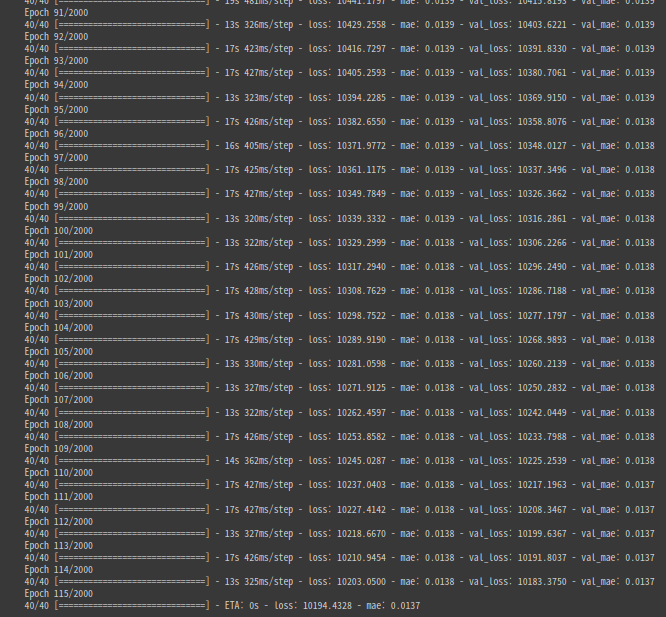

 ```python
 def test_step(self, data):
    x, y, sample_weight = data_adapter.unpack_x_y_sample_weight(data)

    y_pred = self(x, training=False)
    # Updates stateful loss metrics.
    self.compute_loss(x, y, y_pred, sample_weight)
    return self.compute_metrics(x, y, y_pred, sample_weight)  
  ```

  ```python
  def compute_loss(self, x=None, y=None, y_pred=None, sample_weight=None):
    del x  # The default implementation does not use `x`.
    return self.compiled_loss(
        y, y_pred, sample_weight, regularization_losses=self.losses)
  ```

```python
  @traceback_utils.filter_traceback
  def fit(self,
          x=None,
          y=None,
          batch_size=None,
          epochs=1,
          verbose='auto',
          callbacks=None,
          validation_split=0.,
          validation_data=None,
          shuffle=True,
          class_weight=None,
          sample_weight=None,
          initial_epoch=0,
          steps_per_epoch=None,
          validation_steps=None,
          validation_batch_size=None,
          validation_freq=1,
          max_queue_size=10,
          workers=1,
          use_multiprocessing=False):
    base_layer.keras_api_gauge.get_cell('fit').set(True)
    # Legacy graph support is contained in `training_v1.Model`.
    version_utils.disallow_legacy_graph('Model', 'fit')
    self._assert_compile_was_called()
    self._check_call_args('fit')
    _disallow_inside_tf_function('fit')

    if verbose == 'auto':
      if self.distribute_strategy._should_use_with_coordinator:  # pylint: disable=protected-access
        verbose = 2  # Default to epoch-level logging for PSStrategy.
      else:
        verbose = 1  # Default to batch-level logging otherwise.
    elif verbose == 1 and self.distribute_strategy._should_use_with_coordinator:  # pylint: disable=protected-access
      raise ValueError(
          '`verbose=1` is not allowed with `ParameterServerStrategy` for '
          f'performance reasons. Received: `verbose`={verbose}')

    if validation_split:
      # Create the validation data using the training data. Only supported for
      # `Tensor` and `NumPy` input.
      (x, y, sample_weight), validation_data = (
          data_adapter.train_validation_split(
              (x, y, sample_weight), validation_split=validation_split))

    if validation_data:
      val_x, val_y, val_sample_weight = (
          data_adapter.unpack_x_y_sample_weight(validation_data))

    if self.distribute_strategy._should_use_with_coordinator:  # pylint: disable=protected-access
      self._cluster_coordinator = tf.distribute.experimental.coordinator.ClusterCoordinator(
          self.distribute_strategy)

    with self.distribute_strategy.scope(), \
         training_utils.RespectCompiledTrainableState(self):
      # Creates a `tf.data.Dataset` and handles batch and epoch iteration.
      data_handler = data_adapter.get_data_handler(
          x=x,
          y=y,
          sample_weight=sample_weight,
          batch_size=batch_size,
          steps_per_epoch=steps_per_epoch,
          initial_epoch=initial_epoch,
          epochs=epochs,
          shuffle=shuffle,
          class_weight=class_weight,
          max_queue_size=max_queue_size,
          workers=workers,
          use_multiprocessing=use_multiprocessing,
          model=self,
          steps_per_execution=self._steps_per_execution)

      # Container that configures and calls `tf.keras.Callback`s.
      if not isinstance(callbacks, callbacks_module.CallbackList):
        callbacks = callbacks_module.CallbackList(
            callbacks,
            add_history=True,
            add_progbar=verbose != 0,
            model=self,
            verbose=verbose,
            epochs=epochs,
            steps=data_handler.inferred_steps)

      self.stop_training = False
      self.train_function = self.make_train_function()
      self._train_counter.assign(0)
      callbacks.on_train_begin()
      training_logs = None
      # Handle fault-tolerance for multi-worker.
      # TODO(omalleyt): Fix the ordering issues that mean this has to
      # happen after `callbacks.on_train_begin`.
      data_handler._initial_epoch = (  # pylint: disable=protected-access
          self._maybe_load_initial_epoch_from_ckpt(initial_epoch))
      logs = None
      for epoch, iterator in data_handler.enumerate_epochs():
        self.reset_metrics()
        callbacks.on_epoch_begin(epoch)
        with data_handler.catch_stop_iteration():
          for step in data_handler.steps():
            with tf.profiler.experimental.Trace(
                'train',
                epoch_num=epoch,
                step_num=step,
                batch_size=batch_size,
                _r=1):
              callbacks.on_train_batch_begin(step)
              tmp_logs = self.train_function(iterator)
              if data_handler.should_sync:
                context.async_wait()
              logs = tmp_logs  # No error, now safe to assign to logs.
              end_step = step + data_handler.step_increment
              callbacks.on_train_batch_end(end_step, logs)
              if self.stop_training:
                break

        logs = tf_utils.sync_to_numpy_or_python_type(logs)
        if logs is None:
          raise ValueError('Unexpected result of `train_function` '
                           '(Empty logs). Please use '
                           '`Model.compile(..., run_eagerly=True)`, or '
                           '`tf.config.run_functions_eagerly(True)` for more '
                           'information of where went wrong, or file a '
                           'issue/bug to `tf.keras`.')
        epoch_logs = copy.copy(logs)

        # Run validation.
        if validation_data and self._should_eval(epoch, validation_freq):
          # Create data_handler for evaluation and cache it.
          if getattr(self, '_eval_data_handler', None) is None:
            self._eval_data_handler = data_adapter.get_data_handler(
                x=val_x,
                y=val_y,
                sample_weight=val_sample_weight,
                batch_size=validation_batch_size or batch_size,
                steps_per_epoch=validation_steps,
                initial_epoch=0,
                epochs=1,
                max_queue_size=max_queue_size,
                workers=workers,
                use_multiprocessing=use_multiprocessing,
                model=self,
                steps_per_execution=self._steps_per_execution)
          val_logs = self.evaluate(
              x=val_x,
              y=val_y,
              sample_weight=val_sample_weight,
              batch_size=validation_batch_size or batch_size,
              steps=validation_steps,
              callbacks=callbacks,
              max_queue_size=max_queue_size,
              workers=workers,
              use_multiprocessing=use_multiprocessing,
              return_dict=True,
              _use_cached_eval_dataset=True)
          val_logs = {'val_' + name: val for name, val in val_logs.items()}
          epoch_logs.update(val_logs)

        callbacks.on_epoch_end(epoch, epoch_logs)
        training_logs = epoch_logs
        if self.stop_training:
          break

      # If eval data_handler exists, delete it after all epochs are done.
      if getattr(self, '_eval_data_handler', None) is not None:
        del self._eval_data_handler
      callbacks.on_train_end(logs=training_logs)
      return self.history
```

# 31. Index가 섞여서 잘못된 결과가 나오지 않게 하는 방법에 대하여 고민하기

# Purpose
The purpose of this notebook is to review [AutoRec: Autoencoders Meet Collaborative Filtering](https://users.cecs.anu.edu.au/~akmenon/papers/autorec/autorec-paper.pdf).

# Introduction

- Collaborative filtering models make personalised recommendations by using information about users' preferences for items.

- The paper propsed AutoRec, a novel CF based on autoencoder.

- The authors said that the proposed model has representational and computational advantages over other approaches.

# The AutoRec Model

- The basic setup of rating based collaborative filtering
  - $m$ : The number of users.
  - $n$ : The number of items.
  - $R \in \mathbb{R}^{m \times n}$ : A observerd user-item rating matrix which has many missing values.
  - $u \in U = {1,...,m}$ : Each user
    - a partially observed vector 
    $r^{(u)} = (R_{u1},...,R_{un}) \in \mathbb{R}^n$
  - $i \in I = {1,...,n}$
    - a partially observed vector 
    $r^{(i)}=(R_{1i},...,R_{mi}) \in \mathbb{R}^m$

## Purpose
The aim is to design an autoencoder which take each partially observed $r^{(i)} (r^{(u)})$ as input, project the input into a low latent space, and reconstruct ratings in the output space.




The autoencoder optimizes 

$$
min_{\theta} \sum_{r \in S}||r-h(r;\theta)||_2^2
$$

where

$$
h(r;\theta) = f(W \cdot g(Vr+\mu)+b)
$$

$\theta = \{W,V,\mu,b\}$
- $W \in \mathbb{R}^{d\times k} $ : Encoder weights 
- $V \in \mathbb{R}^{k\times d} $ : Decoder weights
- $\mu \in \mathbb{R}^{k}$ : Encoder bias
- $b \in \mathbb{R}^{d}$ : Decoder bias

The autoencoder has a single and k dimesional hidden layer.

# Two important details in the model

1. When updating the model, only observed ratings are considered.

2. To prevent overfitting on the observed ratings, $l2$ regularization loss is applied to $W$ and $V$.

$$
min_{\theta} \sum_{i=1}^{n}||r^{(i)} - h(r^{(i)};\theta)||_O^2 + \frac{\lambda}{2}\cdot(||W||_F^2+||V||_F^2)
$$

where $||\cdot||_O^2$ means only observed ratings are considered to update the model.

$$
\hat R_{ui} = h(r^{(i)};\hat\theta)_u
$$

In [1]:
import os
import math
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import StringLookup

In [2]:
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-1m.zip", "movielens.zip")
ZipFile("movielens.zip", "r").extractall()

# Train test split

- train test data를 어떻게 각각 구했는지 찾던 도중 원 논문의 코드에서 동일한 사이즈의 matrix를 채워넣는 방식을 사용했다는 것을 알 수 있었음. (아래 표시)

In [4]:
def read_rating(path, num_users, num_items,num_total_ratings, a, b, train_ratio):
    fp = open(path + "/ratings.dat")
    user_train_set = set()
    user_test_set = set()
    item_train_set = set()
    item_test_set = set()

    R = np.zeros((num_users,num_items))
    mask_R = np.zeros((num_users, num_items))
    C = np.ones((num_users, num_items)) * b

    train_R = np.zeros((num_users, num_items))
    test_R = np.zeros((num_users, num_items))

    train_mask_R = np.zeros((num_users, num_items)) # 이 부분이 중요
    test_mask_R = np.zeros((num_users, num_items)) #이 부분이 중요

    random_perm_idx = np.random.permutation(num_total_ratings)
    train_idx = random_perm_idx[0:int(num_total_ratings*train_ratio)]
    test_idx = random_perm_idx[int(num_total_ratings*train_ratio):]

    num_train_ratings = len(train_idx)
    num_test_ratings = len(test_idx)

    lines = fp.readlines()
    for line in lines:
        user,item,rating,_ = line.split("::")
        user_idx = int(user) - 1
        item_idx = int(item) - 1
        R[user_idx,item_idx] = int(rating)
        mask_R[user_idx,item_idx] = 1
        C[user_idx,item_idx] = a

    ''' Train '''
    for itr in train_idx:
        line = lines[itr]
        user,item,rating,_ = line.split("::")
        user_idx = int(user) - 1
        item_idx = int(item) - 1
        train_R[user_idx,item_idx] = int(rating)
        train_mask_R[user_idx,item_idx] = 1

        user_train_set.add(user_idx)
        item_train_set.add(item_idx)

    ''' Test '''
    for itr in test_idx:
        line = lines[itr]
        user, item, rating, _ = line.split("::")
        user_idx = int(user) - 1
        item_idx = int(item) - 1
        test_R[user_idx, item_idx] = int(rating)
        test_mask_R[user_idx, item_idx] = 1

        user_test_set.add(user_idx)
        item_test_set.add(item_idx)

    return R, mask_R, C, train_R, train_mask_R, test_R, test_mask_R,num_train_ratings,num_test_ratings,\
user_train_set,item_train_set,user_test_set,item_test_set

R, mask_R, C, train_R, train_mask_R, test_R, test_mask_R,num_train_ratings,num_test_ratings,\
user_train_set,item_train_set,user_test_set,item_test_set =read_rating("ml-1m",6040,3952,1000209,1,0,0.9)

train_R = train_R.T
test_R = test_R.T

In [51]:
class AutoRec(keras.layers.Layer):
  def __init__(self, num_col=32, hidden_node=32,rate=10):
    super(AutoRec, self).__init__()
    self.num_col = num_col
    self.hidden_node = hidden_node
    self.encoder_weight = self.add_weight(
            shape=(num_col, hidden_node), initializer=tf.keras.initializers.truncated_normal(mean=0,stddev=0.03), trainable=True
        )
    self.decoder_weight = self.add_weight(
            shape=(hidden_node, num_col), initializer=tf.keras.initializers.truncated_normal(mean=0,stddev=0.03), trainable=True
        )
    self.encoder_bias = self.add_weight(
            shape=(hidden_node,), initializer="zero", trainable=True
        )
    self.decoder_bias =self.add_weight(
            shape=(num_col,), initializer="zero", trainable=True
        )
    self.rate = rate
    self.encoder_regularization = keras.regularizers.l2(rate*0.5)
    self.decoder_regularization = keras.regularizers.l2(rate*0.5)
    
    

  def call(self,input):
    x=tf.matmul(input,self.encoder_weight) + self.encoder_bias
    x=tf.keras.activations.sigmoid(x)
    out=tf.matmul(x,self.decoder_weight) + self.decoder_bias

    self.add_loss(tf.square(self.encoder_regularization(self.encoder_weight)))
    self.add_loss(tf.square(self.decoder_regularization(self.decoder_weight)))

    #out=keras.activations.sigmoid(x)
    return out



In [60]:
loss_tracker = keras.metrics.Mean(name="loss")
mae_metric = keras.metrics.MeanAbsoluteError(name="mae")


class model(keras.Model):
  '''에러 나서 이 방법 안 쓰기로 함
  공식문서 찾아봐도 이거랑 아래 조합해서 쓰는 예제가 없네..
  def __init__(self,num_col,hidden,rate):
    super(model,self).__init__()
    self.autoencoder = AutoRec(num_col,hidden,rate)

  def call(self,input):
    return self.autoencoder(input)
'''
  def train_step(self,data):
    x,y = data
    
    mask = y !=0
    mask=tf.cast(mask, tf.float32)
    
    ''' masking을 뺀 후에 해서 비교해보기
    '''
    with tf.GradientTape() as tape:
      y=tf.cast(y, tf.float32)
      y_pred=self(x,training=True)
      y_pred=tf.cast(y_pred, tf.float32)
      y_pred=tf.multiply(y_pred,mask)
      dev=tf.multiply((y-y_pred),mask)
      
      #loss=tf.reduce_sum([tf.reduce_sum(tf.math.square(y_pred-y)),tf.reduce_sum(self.losses)])
      loss=tf.reduce_sum([tf.reduce_sum(tf.math.square(dev)),tf.reduce_sum(self.losses)])
    
    

    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)

    self.optimizer.apply_gradients(zip(gradients, trainable_vars))
    loss_tracker.update_state(loss)
    mae_metric.update_state(y, y_pred)
    
    return {"loss": loss_tracker.result(),"mae":mae_metric.result()}
  
  def test_step(self,data):
    x,y = data
    
    mask = y !=0
    mask=tf.cast(mask, tf.float32)
    
    # masking을 뺀 후에 해서 비교해보기
    
    with tf.GradientTape() as tape:
      y=tf.cast(y, tf.float32)
      y_pred=self(x,training=False)
      y_pred=tf.cast(y_pred, tf.float32)
      y_pred=tf.multiply(y_pred,mask)
      dev=tf.multiply((y-y_pred),mask)
      
      #loss=tf.reduce_sum([tf.reduce_sum(tf.math.square(y_pred-y)),tf.reduce_sum(self.losses)])
      loss=tf.reduce_sum([tf.reduce_sum(tf.math.square(dev)),tf.reduce_sum(self.losses)])
    
    

    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)

    self.optimizer.apply_gradients(zip(gradients, trainable_vars))
    loss_tracker.update_state(loss)
    mae_metric.update_state(y, y_pred)
    
    return {"loss": loss_tracker.result(),"mae":mae_metric.result()}
    

In [52]:
loss_tracker = keras.metrics.Mean(name="loss")
mae_metric = keras.metrics.MeanAbsoluteError(name="mae")


class model(keras.Model):
  '''에러 나서 이 방법 안 쓰기로 함
  공식문서 찾아봐도 이거랑 아래 조합해서 쓰는 예제가 없네..
  def __init__(self,num_col,hidden,rate):
    super(model,self).__init__()
    self.autoencoder = AutoRec(num_col,hidden,rate)

  def call(self,input):
    return self.autoencoder(input)
'''
  def train_step(self,data):
    x,y = data
    
    mask = y !=0
    mask=tf.cast(mask, tf.float32)
    
    ''' masking을 뺀 후에 해서 비교해보기
    '''
    with tf.GradientTape() as tape:
      y=tf.cast(y, tf.float32)
      y_pred=self(x,training=True)
      y_pred=tf.cast(y_pred, tf.float32)
      y_pred=tf.multiply(y_pred,mask)
      dev=tf.multiply((y-y_pred),mask)
      
      #loss=tf.reduce_sum([tf.reduce_sum(tf.math.square(y_pred-y)),tf.reduce_sum(self.losses)])
      loss=tf.reduce_sum([tf.reduce_sum(tf.math.square(dev)),tf.reduce_sum(self.losses)])
    
    

    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)

    self.optimizer.apply_gradients(zip(gradients, trainable_vars))
    loss_tracker.update_state(loss)
    mae_metric.update_state(y, y_pred)
    
    return {"loss": loss_tracker.result(),"mae":mae_metric.result()}

#### Learning rate scheduler 설정
- [tf2](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay)

- [원래 코드](https://github.com/gtshs2/Autorec/blob/master/AutoRec.py#L48)

In [61]:
base_lr = 0.001
decay_epoch_step = 50
decay_step = decay_epoch_step * 2000

lr = tf.keras.optimizers.schedules.ExponentialDecay(base_lr, decay_step, 0.96, staircase=True)

In [62]:
input=layers.Input(shape = (train_R.shape[1]))
output= AutoRec(train_R.shape[1],500,0.1)(input)
m = model(input,output)
m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),run_eagerly=True)

In [ ]:
m.fit(train_R, train_R, epochs=2000,batch_size = 100,validation_data=(test_R,test_R))

In [66]:
R

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]])

In [68]:
pd.DataFrame(test_R)

,0,1,2,3,4,5,6,7,8,9,...,6030,6031,6032,6033,6034,6035,6036,6037,6038,6039
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
prediction=pd.DataFrame(m.predict(test_R))
prediction

,0,1,2,3,4,5,6,7,8,9,...,6030,6031,6032,6033,6034,6035,6036,6037,6038,6039
0,4.269849,4.559980,3.820529,3.968242,3.939121,4.570422,4.143572,3.921419,3.757900,5.135484,...,3.188660,3.075571,4.620615,4.369749,4.286237,3.664926,4.495758,3.439692,2.821030,3.501525
1,3.371311,3.296499,2.918303,2.924408,2.794932,3.726820,3.151858,2.901623,2.610207,4.000312,...,2.762802,2.027361,3.519398,3.299904,2.495849,2.493927,3.306774,2.704574,2.109662,2.545806
2,3.340233,3.437084,2.901448,2.959359,2.739522,3.885939,3.126202,2.891349,2.501140,3.995842,...,2.689023,1.926545,3.559191,3.274365,2.371107,2.223269,3.388163,2.768856,2.035825,2.637480
3,3.164112,3.244668,2.705391,2.824123,2.722995,3.784986,2.909558,2.607114,2.246508,3.851190,...,2.567135,1.850844,3.328660,3.160958,2.136203,2.280315,3.206427,2.723133,1.980719,2.582079
4,3.232276,3.270382,2.802179,2.868766,2.800161,3.779305,3.005003,2.720638,2.367953,3.949438,...,2.632648,1.948496,3.428038,3.210392,2.192896,2.305467,3.286728,2.697782,1.997020,2.507031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3947,3.725751,3.850840,3.289406,3.424365,3.317533,4.191067,3.571663,3.224163,2.932528,4.302438,...,2.831915,2.388963,4.006179,3.812402,2.977130,2.725778,3.866674,3.025431,2.409016,3.117174
3948,3.598744,3.637022,3.062227,3.342618,3.573561,4.166795,3.347187,3.233093,2.853486,4.388726,...,2.610492,2.519918,3.870344,3.851953,3.225376,3.153057,3.786529,3.094776,2.400451,3.371178
3949,3.321022,3.391378,2.890891,3.059337,3.051553,3.909840,3.113080,2.882997,2.438820,3.908564,...,2.525819,2.045599,3.510451,3.456529,2.408358,2.566618,3.499654,2.861902,2.126170,3.066925
3950,3.185268,3.259525,2.736049,2.916785,2.930283,3.800532,2.959980,2.756658,2.302923,3.774145,...,2.465759,1.934986,3.357018,3.298642,2.271826,2.420208,3.330819,2.763608,2.030420,2.904719
